In [1]:
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import model_from_json

In [3]:
import cv2
import numpy as np

In [4]:
font = cv2.FONT_HERSHEY_COMPLEX
img_width, img_height = 48, 48

In [87]:
def get_contours(img, low_threshold=250, high_threshold=255):
    _, threshold = cv2.threshold(img, low_threshold, high_threshold, cv2.THRESH_BINARY)
    #threshold = cv2.Canny(threshold,220,255)
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    return contours

In [6]:
def count_contours(img, contours):
    parking_bay_count = 0
    parking_bounding_boxes_4_corners = []
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
        cv2.drawContours(img, [approx], 0, (0), 5)
        x = approx.ravel()[0]
        y = approx.ravel()[1]
        #print(len(approx), approx)
        if len(approx) == 3:
            cv2.putText(img, "Triangle", (x, y), font, 1, (255))
        elif len(approx) == 4:
            parking_bay_count = parking_bay_count + 1
            #top_left_point=tuple(approx[0][0])
            #bottom_right_point=tuple(approx[2][0])
            parking_bounding_boxes_4_corners.append(approx)
            cv2.putText(img, "Rectangle", (x, y), font, 1, (255))
        elif len(approx) == 5:
            cv2.putText(img, "Pentagon", (x, y), font, 1, (0))
        elif 6 < len(approx) < 15:
            cv2.putText(img, "Ellipse", (x, y), font, 1, (0))
        else:
            cv2.putText(img, "Circle", (x, y), font, 1, (0))

    print("number of parking bays:", parking_bay_count)
    
    return (parking_bay_count,parking_bounding_boxes_4_corners)

In [7]:
def get_parking_bay_images(img, parking_bounding_boxes):
    parking_bays_image_data=[]
    parking_bays_rectangles_top_bottom_corners=[]
    for box in parking_bounding_boxes:
        #print('Box:', box)

        top_left_point=tuple(box[0][0])
        bottom_right_point=tuple(box[2][0])

        parking_bays_rectangles_top_bottom_corners.append([top_left_point,bottom_right_point])
        #print('Rectangle Points:', top_left_point, bottom_right_point)

        #CROP IMAGE of each parking bay and append the cropped image data
        # dim-1 is height, is dim-0 is width
        # for rectangle dimensions (944, 392) (1080, 575), 
        #extract portion of image starting from height: 392 to 572 and
        # width 944 to 1080
        bay = img[top_left_point[1]:bottom_right_point[1],top_left_point[0]:bottom_right_point[0] ]


        parking_bays_image_data.append(bay)
    return parking_bays_image_data,parking_bays_rectangles_top_bottom_corners

In [8]:
def load_model(model_json='carpark_model.json', model_weights='carpark_model.h5'):
    # load json and create model
    json_file = open(model_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_weights)
    print("Loaded model from disk")
    # evaluate loaded model on test data
    loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return loaded_model

In [9]:
def get_parking_status(img_color, 
                       loaded_model,
                       parking_bays_image_data,
                       parking_bays_rectangles_top_bottom_corners):
    number_of_bays = len(parking_bays_image_data)-1
    
    for i in range(len(parking_bays_image_data)):
        if (parking_bays_image_data[number_of_bays-i].shape[1] != 0):
            bay_img = cv2.resize(parking_bays_image_data[number_of_bays-i], (img_width,img_height))
            bay_img = bay_img.reshape(1,img_width,img_height,3)
            status = loaded_model.predict(bay_img)
            if status > 0.5:
                print(i+1,':' , 'Occupied')
                cv2.rectangle(img_color,
                             parking_bays_rectangles_top_bottom_corners[number_of_bays-i][0], 
                             parking_bays_rectangles_top_bottom_corners[number_of_bays-i][1],
                             color=(255,0,0),thickness=3)
            else:
                print(i+1, ':' , 'Free')
                cv2.rectangle(img_color,
                             parking_bays_rectangles_top_bottom_corners[number_of_bays-i][0], 
                             parking_bays_rectangles_top_bottom_corners[number_of_bays-i][1],
                             color=(0,255,0),thickness=3)
    #plt.imshow(img_color)

# Parking Status Pipeline - Step By Step

### 1. Load Image

In [29]:
# 1. load image
img = cv2.imread("parking_bays_2.png", cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread("parking_bays_2.png")

In [30]:
print('image shape:', img.shape)

image shape: (671, 1204)


Text(0.5, 1.0, 'Color')

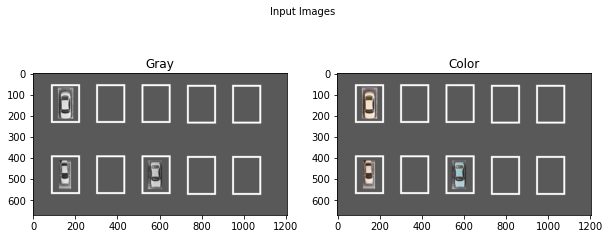

In [31]:
fig = plt.figure(figsize=(10, 4))
fig.suptitle("Input Images", fontsize=10)
p1=plt.subplot(1,2,1)
p1.imshow(img,cmap='gray')
p1.set_title("Gray")
p2 = plt.subplot(1,2,2)
p2.imshow(img_color)
p2.set_title("Color")

### 2 - get countours

In [32]:
contours = get_contours(img,250,255)

### 3 Count parking bays & get corners co-ordinates

In [33]:
bay_cnt, contour_corners = count_contours(img, contours)

number of parking bays: 10


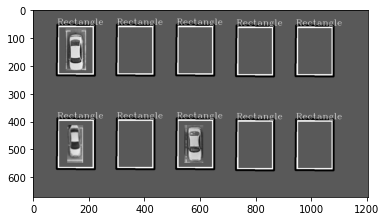

In [34]:
plt.imshow(img, cmap='gray')

### 4 Crop parking bays images

In [35]:
bay_img_data, bay_top_bottom_corners = get_parking_bay_images(img_color, contour_corners)

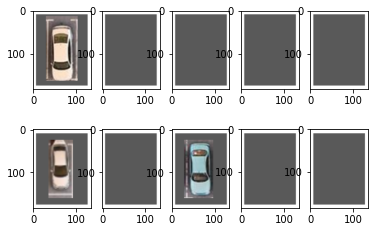

In [36]:
for i in range(len(bay_img_data)):
    plt.subplot(2,5,i+1)
    plt.imshow(bay_img_data[9-i]) #the indexes are reversed in cv2 contours boxes

### 5. Load trained model

In [37]:
model = load_model()

Loaded model from disk


### 6 Calculare parking status

In [38]:
get_parking_status(img_color,model, bay_img_data, bay_top_bottom_corners)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1 : Occupied
2 : Free
3 : Free
4 : Free
5 : Free
6 : Occupied
7 : Free
8 : Occupied
9 : Free
10 : Free


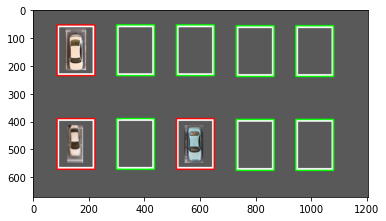

In [255]:
plt.imshow(img_color)

In [256]:
# Parking Status Pipeline - End to End

In [39]:
model = load_model()

Loaded model from disk


In [61]:
def parking_status_pipeline(image, model):
    try:
        image_copy = np.copy(image)
        img = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
        #img = cv2.GaussianBlur(img, (5, 5), 0)
        contours = get_contours(img,240,255)
        bay_cnt, contour_corners = count_contours(img, contours)
        bay_img_data, bay_top_bottom_corners = get_parking_bay_images(image_copy, contour_corners)
        #model = load_model()
        get_parking_status(image_copy,model, bay_img_data, bay_top_bottom_corners)
        return image_copy
    except:
        return image

number of parking bays: 10
1 : Occupied
2 : Free
3 : Free
4 : Free
5 : Free
6 : Free
7 : Free
8 : Free
9 : Free
10 : Free


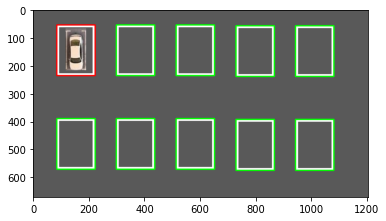

In [58]:

image = cv2.imread("parking_bays_1.png")
img_out=parking_status_pipeline(image, model)
plt.imshow(img_out)

number of parking bays: 10
1 : Occupied
2 : Occupied
3 : Free
4 : Occupied
5 : Free
6 : Occupied
7 : Free
8 : Occupied
9 : Occupied
10 : Free


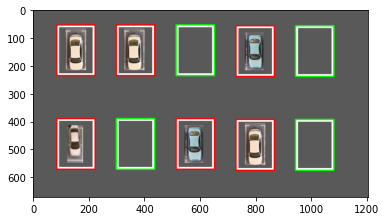

In [59]:
image = cv2.imread("parking_bays_3.png")
img_out=parking_status_pipeline(image, model)
plt.imshow(img_out)

number of parking bays: 10
1 : Occupied
2 : Free
3 : Free
4 : Free
5 : Free
6 : Occupied
7 : Free
8 : Occupied
9 : Free
10 : Free


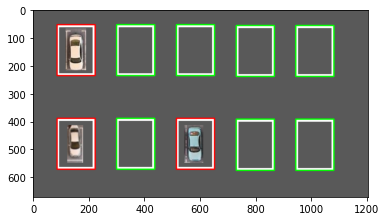

In [43]:
image = cv2.imread("parking_bays_2.png")
img_out=parking_status_pipeline(image, model)
plt.imshow(img_out)

number of parking bays: 5
1 : Free
2 : Free
3 : Free
4 : Free
5 : Free


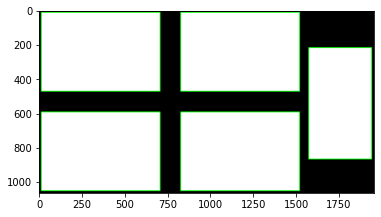

In [111]:
image = cv2.imread("cnn_model_cars_11.png")
img_out=parking_status_pipeline(image, model)
plt.imshow(img_out)

number of parking bays: 5
1 : Occupied
2 : Free
3 : Free
4 : Free
5 : Free


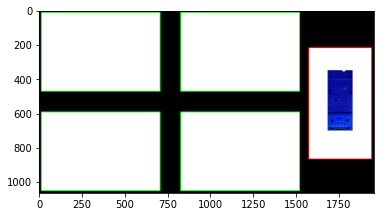

In [112]:
image = cv2.imread("cnn_model_cars_12.png")
img_out=parking_status_pipeline(image, model)
plt.imshow(img_out)

number of parking bays: 5
1 : Occupied
2 : Occupied
3 : Free
4 : Free
5 : Free


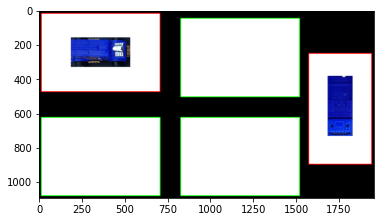

In [114]:
image = cv2.imread("cnn_model_cars_13.png")
img_out=parking_status_pipeline(image, model)
plt.imshow(img_out,cmap='gray')

# Real Images Experimentation

number of parking bays: 0


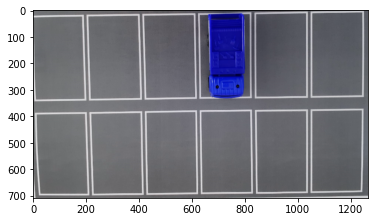

In [101]:
image = cv2.imread("cnn_model_cars_9.png")
#img = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
img_out=parking_status_pipeline(image, model)
plt.imshow(img_out)

In [107]:
image = cv2.imread("cnn_model_cars_9.png")
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
c1=get_contours(img,240,255)

0


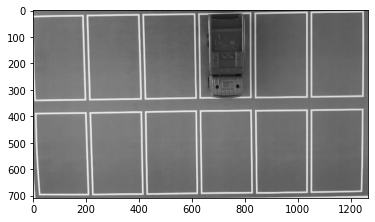

In [109]:
plt.imshow(img,cmap='gray')
print(len(c1))

In [97]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#gray = cv2.bilateralFilter(gray, 100, 150, 17)
edged = cv2.Canny(gray, 30, 200)

error: OpenCV(4.5.1) c:\users\appveyor\appdata\local\temp\1\pip-req-build-vijyisc5\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x4be89496::Set<1,-1,-1>,struct cv::impl::A0x4be89496::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


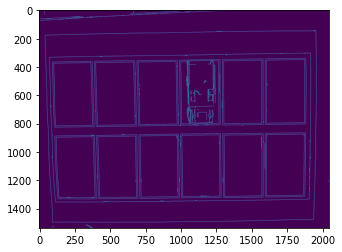

In [65]:
plt.imshow(edged)

In [66]:
import imutils

In [76]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)
screenCnt = None

In [77]:
len(cnts)

209

In [78]:
parking_bay_count = 0
parking_bounding_boxes_4_corners = []
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.015 * peri, True)
    x = approx.ravel()[0]
    y = approx.ravel()[1]
    # if our approximated contour has four points, then
    # we can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        parking_bay_count = parking_bay_count + 1
        parking_bounding_boxes_4_corners.append(approx)
        cv2.putText(gray, "Rectangle", (x, y), font, 1, (255))


In [79]:
parking_bay_count

63

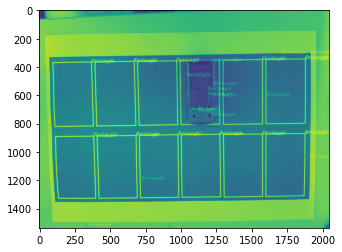

In [80]:
plt.imshow(gray)

In [81]:
bay_img_data, bay_top_bottom_corners = get_parking_bay_images(np.copy(image), parking_bounding_boxes_4_corners)

In [82]:
bay_img_data[9].shape

(464, 0, 3)

In [83]:
get_parking_status(image,model, bay_img_data, bay_top_bottom_corners)

1 : Occupied
2 : Free


error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-vijyisc5\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


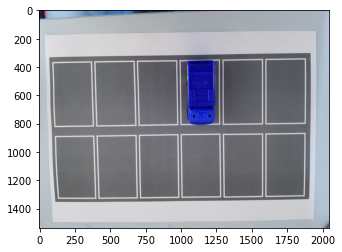

In [84]:
plt.imshow(image)